In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.externals import joblib
from helpers import prepPlot
from keras.models import load_model

def addProb_temp(df, cl, sc, sk):
    if sk:
        df['prob']= df.apply(lambda x: float(cl.predict_proba(sc.transform(x.values.reshape(1, -1)))[0][1]), axis=1)
    else:
        df['prob']= df.apply(lambda x: \
                             float(cl.predict_proba(np.expand_dims(sc.transform(x.values.reshape(1, -1)),axis=2))[0])
                                   , axis=1)
    return df

cutsNew={}
cutsNew['DD']=0.90
cutsNew['LL']=0.95
cutsNew['None']=0.90

# Load signal region classifier
load_folder = '/Users/sbenson/Documents/BsGammaGamma/'
dfs = []
topos = ['LL', 'DD', 'None']

varsCaloChosen = ['calog_ShowerShape', 'calog_LOKI_CaloNeutralE49'
         , 'calog_LOKI_CaloNeutralPrsM', 'calog_LOKI_CaloNeutralSpd'
         , 'calog_LOKI_IsPhoton']
varsCaloChosen = [v.replace('calog','photon') for v in varsCaloChosen]
varsConvChosen = [
    'photon_conv_PT', 'photon_conv_MMERR'
    , 'photon_conv_LOKI_ENDVERTEX_CHI2DOF', 'pos_LOKI_CaloEcalE', 'ele_LOKI_CaloEcalE'
]
varsConvLLChosen = ['photon_conv_LOKI_BPVIP']

Using TensorFlow backend.


In [2]:
for t in topos:
    if t =='LL':
        vars_for_training = varsCaloChosen + varsConvChosen + varsConvLLChosen
    elif t == 'DD':
        vars_for_training = varsCaloChosen + varsConvChosen
    else:
        vars_for_training = [v.replace('photon','photon1') for v in varsCaloChosen]
        vars_for_training += [v.replace('photon','photon2') for v in varsCaloChosen]
    dfs.append(pd.read_hdf(load_folder+'combined_%s.h5' % t))
    loc_class = 'classifier_%s' % t
    loc_scale = 'scaler_%s' % t
    classifier = load_model(load_folder+loc_class+'.h5')
    scaler = joblib.load(load_folder+loc_scale)
    df_dsig_red = dfs[-1].loc[:,vars_for_training]
    df_dsig_red = addProb_temp(df_dsig_red, classifier, scaler, False)
    dfs[-1] = dfs[-1][df_dsig_red['prob']>cutsNew[t]]

/Users/sbenson/anaconda3/envs/testenv/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


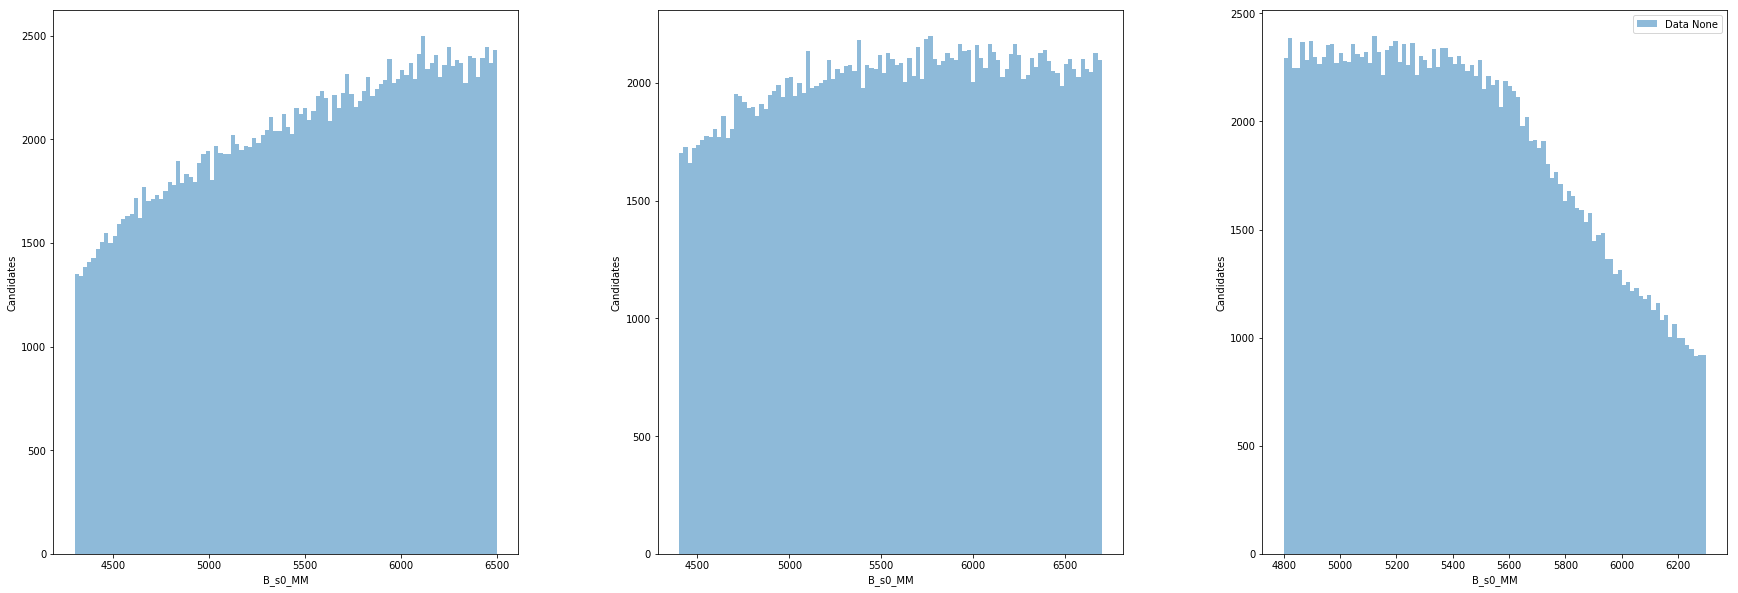

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
for n, t in enumerate(topos):
    vname = 'B_s0_MM'
    h_mm_data = dfs[n].hist(column=[vname], ax=axes[n], label = "Data %s" % t
                                               , bins = 100, alpha=0.5)
    prepPlot(axes[n], vname, "Candidates")
    plt.legend()
plt.show()